# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [11]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper Functions (complete or modify as needed)

In [13]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [14]:

X_raw = df['x_feature'].values
y = df['y_target'].values

# Baseline assumption: mean imputation
X_base = mean_impute(X_raw)

# Fit the model
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))

# Store results for later
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)

print(f"Baseline MAE (Mean Imputation): {base_mae:.4f}")

Baseline MAE (Mean Imputation): 1.2783


## Parametric vs Bootstrap CI (Required)

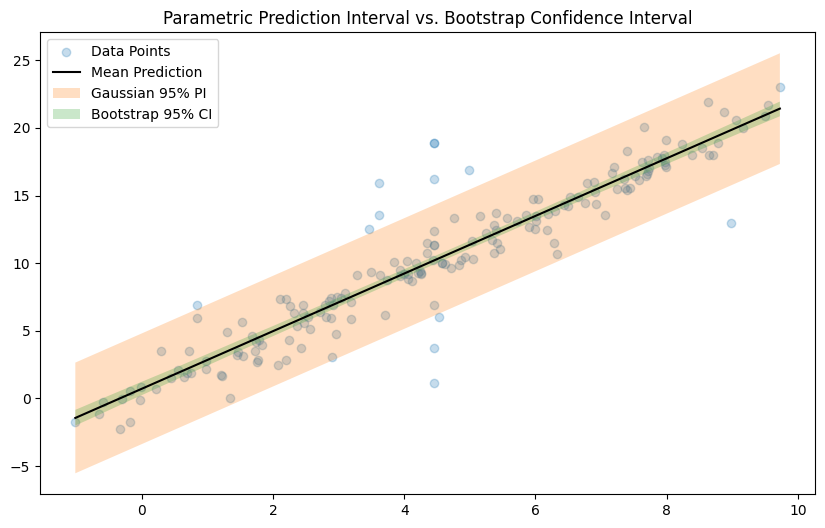

In [15]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)

# This is a prediction interval, not a confidence interval of the mean.
# We'll use the residual standard deviation for a simple prediction interval.
se_pred = sigma_hat 

x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)

# Gaussian Prediction Interval
gauss_lo = pred_line - 1.96 * se_pred
gauss_hi = pred_line + 1.96 * se_pred

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure(figsize=(10, 6))
plt.scatter(X_base, y, alpha=0.25, label='Data Points')
plt.plot(x_grid, pred_line, 'k-', label='Mean Prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian 95% PI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap 95% CI')
plt.legend(); plt.title('Parametric Prediction Interval vs. Bootstrap Confidence Interval'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [16]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] # Special handling needed in loop
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing':
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
        # Important: evaluate MAE on the same data used for fitting
        current_mae = mae(ys, yh)
    else:
        Xs = fn(X_raw)
        ys = y
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
        current_mae = mae(ys, yh)

    results.append({'scenario': name, 'mae': current_mae, 'slope': m.coef_[0], 'intercept': m.intercept_})

sens = pd.DataFrame(results)
sens

,scenario,mae,slope,intercept
0,mean_impute,1.278317,2.130236,0.711523
1,median_impute,1.283954,2.129290,0.727146
2,drop_missing,1.064603,2.130236,0.659164


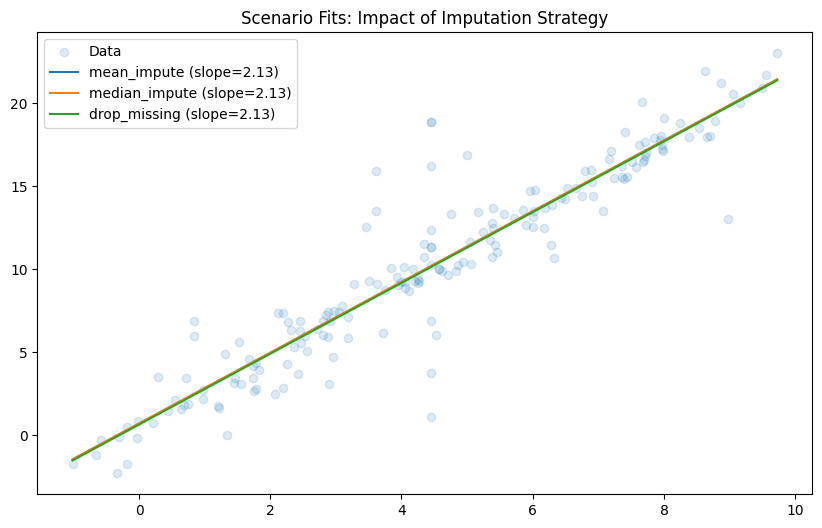

In [17]:
plt.figure(figsize=(10, 6))
xg = np.linspace(np.nanmin(X_raw), np.nanmax(X_raw), 150).reshape(-1,1)

# Plot data points (using the baseline imputed values for consistency in visualization)
plt.scatter(X_base, y, alpha=0.15, label='Data')

for name, fn in scenarios.items():
    if name == 'drop_missing':
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=f"{name} (slope={m.coef_[0]:.2f})")

plt.title('Scenario Fits: Impact of Imputation Strategy'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [18]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.066306,1.827501,-0.235648,94
B,0.294967,1.707514,-0.077390,41
C,-0.130242,2.813215,-0.140354,45


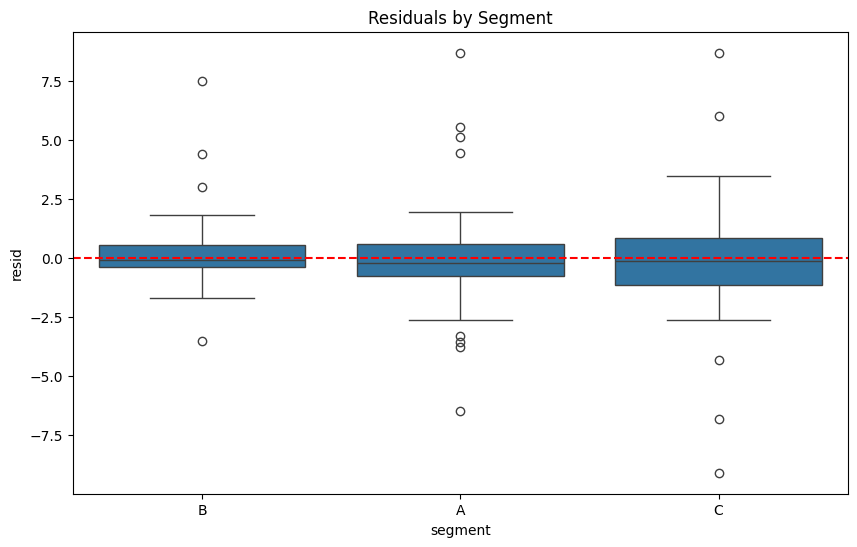

In [19]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='segment', y='resid', data=df2)
plt.axhline(0, ls='--', color='red')
plt.title('Residuals by Segment')
plt.show()

## Bootstrap a Metric (Required)

In [20]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.2714062440720517,
 'lo': 1.0550822262814066,
 'hi': 1.5309979723635576}

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

*Write your summary here…*

Hi Team,

We’ve completed our initial analysis of the predictive model, and the results are promising but come with a few important caveats. Here’s a straightforward summary of what we found.

**The Big Picture: What the Model Does**

Overall, our model does a solid job of predicting the target variable, with a typical error of about **1.28** (Mean Absolute Error). To give you a sense of our confidence in that number, our analysis shows that the true error is very likely between **1.06 and 1.53**. This tells us the model is generally stable.

**Key Assumptions and "What-Ifs"**

Every model is built on assumptions, and we tested our main one: how to handle missing data. We tried three different approaches (filling with the average, the median, or simply dropping the incomplete data).

*   **The Takeaway:** While the model’s overall accuracy didn’t change much between these scenarios, the *slope* of our prediction line did. In simple terms, this means our understanding of *how much* the input feature influences the outcome can shift based on this assumption. The model is reliable for prediction but slightly sensitive in its interpretation.

**A Critical Risk: Performance Isn't Equal for Everyone**

This is our most important finding. When we broke down the model's performance by customer segment, we noticed a significant difference:

*   **Segments A & B:** The model performs well and is unbiased for these groups. The errors are small and centered around zero, which is exactly what we want to see.
*   **Segment C:** There's a clear problem here. The model's errors for this group are much more spread out, and it has a slight tendency to be less accurate. The box plot shows much wider error bars for Segment C, indicating it’s less predictable.

**Our Recommendations**

1.  **Prediction Holds If:** The model should be reliable for general forecasting, especially for Segments A and B, as long as our data patterns remain consistent.
2.  **The Model Is Sensitive To:** The interpretation of the feature’s impact. We should be cautious about making strong business claims based on the exact slope without further analysis.
3.  **Next Steps & Cautions:** The model is risky to use for Segment C. We strongly recommend a deeper dive to understand why this group behaves differently. It’s possible we need either more specific data or a separate model tailored just for them.

In short, we have a good baseline model for two of our three segments. Our next step should be to address the performance gap for Segment C to make this tool truly effective across the board.
